# Chapter 16 — Sampling plans & space-filling metrics (Notebook v2)

**Scope (the “figure at end of chapter”):** evaluate **5 sampling plans** in 2D:
- Random
- Additive Recurrence
- Halton
- Sobol (**fixed**: generate \(2^k\) then slice → no warning)
- Uniform Projection (LHS)

**Budgets:** \(m \in \{10, 100, 1000\}\)

**Metrics (3):**
1) **Star-discrepancy (MC approx)** — lower is better  
2) **Nearest-neighbor distance** (min/mean/median; boxplot uses per-point NN distances) — higher is better  
3) **Morris–Mitchell \(\Phi_q\)** — lower is better (**improved**: normalized by number of pairs so it doesn’t “blow up” with \(m\))

**Outputs saved:**
- Figures in `img/`
- Raw + summary CSV in `results/`

> Tip: run the whole notebook top-to-bottom. It is designed to be warning-clean without suppressing warnings.


In [1]:
# =========================
# 0) Imports & global setup
# =========================

from __future__ import annotations

import math
from dataclasses import dataclass
from pathlib import Path
from typing import Callable, Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import qmc
from scipy.spatial import cKDTree
from scipy.spatial.distance import pdist

# Reproducibility: stable-ish rendering
plt.rcParams.update({
    "figure.dpi": 110,
    "savefig.dpi": 300,
    "font.size": 10,
})

# Output folders
IMG_DIR = Path("img")
RES_DIR = Path("results")
IMG_DIR.mkdir(parents=True, exist_ok=True)
RES_DIR.mkdir(parents=True, exist_ok=True)

print("IMG_DIR:", IMG_DIR.resolve())
print("RES_DIR:", RES_DIR.resolve())


IMG_DIR: C:\Users\LENOVO\OneDrive - VNU-HCMUS\HK5\CSAI\LAB_3\img
RES_DIR: C:\Users\LENOVO\OneDrive - VNU-HCMUS\HK5\CSAI\LAB_3\results


## 1) Sampling methods (5)

All samplers return an array `X` of shape `(m, d)` in the unit hypercube \([0,1]^d\).


In [2]:
# =========================
# 1) Sampling implementations
# =========================

def sample_random(m: int, d: int, seed: int) -> np.ndarray:
    rng = np.random.default_rng(seed)
    return rng.random((m, d))


def _first_primes(n: int) -> List[int]:
    # Simple prime generator (enough for small d)
    primes: List[int] = []
    x = 2
    while len(primes) < n:
        is_prime = True
        for p in primes:
            if p * p > x:
                break
            if x % p == 0:
                is_prime = False
                break
        if is_prime:
            primes.append(x)
        x += 1
    return primes


def sample_additive_recurrence(m: int, d: int, seed: int) -> np.ndarray:
    # Additive recurrence:
    #   x_k = (x0 + (k+1)*alpha) mod 1
    # where alpha uses irrational components (frac(sqrt(primes))).
    rng = np.random.default_rng(seed)
    x0 = rng.random(d)
    primes = np.array(_first_primes(d), dtype=float)
    alpha = np.mod(np.sqrt(primes), 1.0)
    alpha = np.where(alpha < 1e-12, alpha + 0.5, alpha)  # avoid near-zero step

    k = np.arange(1, m + 1).reshape(-1, 1)  # 1..m
    X = (x0 + k * alpha.reshape(1, -1)) % 1.0
    return X


def sample_halton(m: int, d: int, seed: int, scramble: bool = True) -> np.ndarray:
    eng = qmc.Halton(d=d, scramble=scramble, seed=seed)
    return eng.random(n=m)


def sample_sobol(m: int, d: int, seed: int, scramble: bool = True) -> np.ndarray:
    # Warning-clean Sobol:
    # generate 2^k points (random_base2) then slice the first m.
    eng = qmc.Sobol(d=d, scramble=scramble, seed=seed)
    k = int(np.ceil(np.log2(max(1, m))))
    X = eng.random_base2(m=k)  # size = 2^k, warning-free
    return X[:m]


def sample_lhs(m: int, d: int, seed: int, scramble: bool = True) -> np.ndarray:
    eng = qmc.LatinHypercube(d=d, scramble=scramble, seed=seed)
    return eng.random(n=m)


METHODS: Dict[str, Callable[..., np.ndarray]] = {
    "random": sample_random,
    "addrec": sample_additive_recurrence,
    "halton": sample_halton,
    "sobol": sample_sobol,
    "lhs": sample_lhs,
}

METHOD_LABEL = {
    "random": "Random",
    "addrec": "Additive Recurrence",
    "halton": "Halton",
    "sobol": "Sobol",
    "lhs": "Uniform Projection (LHS)",
}

print("Methods:", list(METHODS.keys()))


Methods: ['random', 'addrec', 'halton', 'sobol', 'lhs']


## 2) Visualizing sampling patterns (like the book’s end-of-chapter figure)

We plot a grid: rows = budgets \(m\), columns = methods.  
Points are colored by sampling order (early → late).


Saved: img\fig_ch16_sampling_summary_v2.png


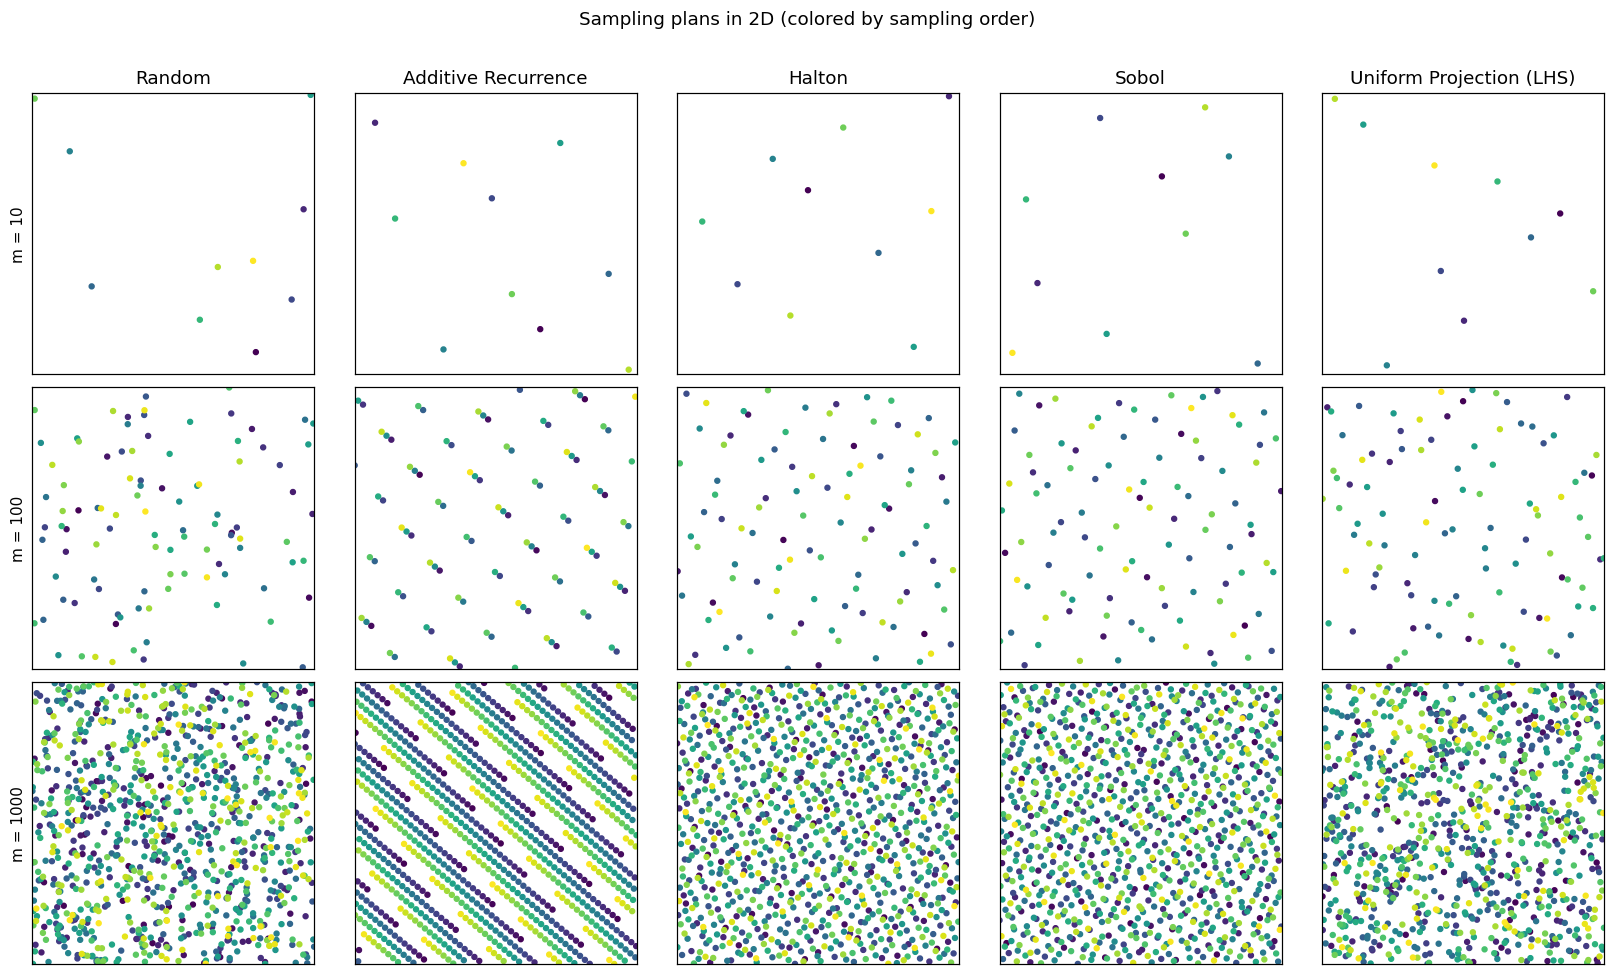

In [3]:
# =========================
# 2) Visualization helpers
# =========================

def plot_sampling_grid(
    d: int,
    m_list: List[int],
    methods: List[str],
    seed: int,
    savepath: Path | None = None,
) -> plt.Figure:
    assert d == 2, "This visualization is written for 2D (d=2)."

    n_rows = len(m_list)
    n_cols = len(methods)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.0 * n_cols, 3.0 * n_rows), squeeze=False)

    for r, m in enumerate(m_list):
        for c, method in enumerate(methods):
            ax = axes[r, c]
            X = METHODS[method](m=m, d=d, seed=seed + 1000 * r + 50 * c)

            colors = np.linspace(0, 1, m)
            ax.scatter(X[:, 0], X[:, 1], c=colors, s=10)

            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.set_aspect("equal", adjustable="box")
            ax.set_xticks([])
            ax.set_yticks([])

            if r == 0:
                ax.set_title(METHOD_LABEL[method])
            if c == 0:
                ax.set_ylabel(f"m = {m}")

    fig.suptitle("Sampling plans in 2D (colored by sampling order)", y=0.98, fontsize=12)
    fig.tight_layout(rect=[0, 0, 1, 0.97])

    if savepath is not None:
        fig.savefig(savepath, bbox_inches="tight")
        print("Saved:", savepath)

    return fig


D = 2
M_LIST = [10, 100, 1000]
METHOD_LIST = ["random", "addrec", "halton", "sobol", "lhs"]
BASE_SEED = 20251326

fig_path = IMG_DIR / "fig_ch16_sampling_summary_v2.png"
_ = plot_sampling_grid(d=D, m_list=M_LIST, methods=METHOD_LIST, seed=BASE_SEED, savepath=fig_path)
plt.show()


## 3) Metrics (3)

### 3.1 Star-discrepancy (MC approximation)
Approximate star discrepancy by sampling many anchor boxes \([0, u]\):
\[
D^\*(X) \approx \max_u \left| \frac{1}{m}\sum_{i=1}^m \mathbb{1}(x_i \le u) - \prod_j u_j \right|.
\]

### 3.2 Nearest-neighbor distance
Compute NN distance for each point (KDTree query) and summarize (min/mean/median).

### 3.3 Morris–Mitchell \(\Phi_q\) (normalized)
Normalized version (so it doesn’t explode with \(m\)):
\[
\Phi^{norm}_q(X)=\left(\frac{1}{\#pairs}\sum d_{ij}^{-q}\right)^{1/q}.
\]


In [4]:
# =========================
# 3) Metric implementations
# =========================

def star_discrepancy_mc(
    X: np.ndarray,
    rng: np.random.Generator,
    R: int = 2000,
    chunk: int = 256,
) -> float:
    # Monte Carlo approximation of star discrepancy D*(X) over [0,1]^d.
    m, d = X.shape
    U = rng.random((R, d))
    vols = np.prod(U, axis=1)

    max_dev = 0.0
    for start in range(0, R, chunk):
        end = min(R, start + chunk)
        Uc = U[start:end]  # (c, d)

        dominated = (X[None, :, :] <= Uc[:, None, :]).all(axis=2)  # (c, m)
        cdf = dominated.mean(axis=1)  # (c,)

        dev = np.max(np.abs(cdf - vols[start:end]))
        if dev > max_dev:
            max_dev = float(dev)

    return max_dev


def nearest_neighbor_stats(X: np.ndarray):
    # Returns nn_min, nn_mean, nn_median, nn_all (per-point NN distances)
    tree = cKDTree(X)
    dists, _ = tree.query(X, k=2)
    nn = dists[:, 1]
    return float(nn.min()), float(nn.mean()), float(np.median(nn)), nn


def phi_q_normalized(X: np.ndarray, q: float = 1.0) -> float:
    # Normalized Morris–Mitchell Phi_q: (mean(d_ij^{-q}))^{1/q}
    dists = pdist(X, metric="euclidean")
    dists = np.maximum(dists, 1e-12)
    return float((np.mean(dists ** (-q))) ** (1.0 / q))


## 4) Experiment runner

We repeat each configuration multiple times (**reps**) with controlled seeds.
We save:
- `results/metrics_raw.csv`
- `results/metrics_summary.csv`

We also keep per-point NN distances to build the boxplot.


In [5]:
# =========================
# 4) Experiment runner
# =========================

@dataclass(frozen=True)
class ExperimentConfig:
    d: int = 2
    m_list: Tuple[int, ...] = (10, 100, 1000)
    methods: Tuple[str, ...] = ("random", "addrec", "halton", "sobol", "lhs")
    n_reps: int = 5
    base_seed: int = 20251326

    # Discrepancy MC budget
    disc_R_small: int = 2000
    disc_R_large: int = 10000
    disc_large_at_m: int = 1000

    # Phi_q values (q=1 main; q=10 extra maximin-like)
    phi_qs: Tuple[float, ...] = (1.0, 10.0)


def _seed_for(cfg: ExperimentConfig, rep: int, method: str, m: int) -> int:
    method_idx = list(cfg.methods).index(method)
    m_idx = list(cfg.m_list).index(m)
    return int(cfg.base_seed + 10000 * rep + 100 * method_idx + 7 * m_idx)


def run_experiment(cfg: ExperimentConfig):
    rows = []
    nn_store: Dict[Tuple[str, int], List[np.ndarray]] = {}

    for rep in range(cfg.n_reps):
        for method in cfg.methods:
            for m in cfg.m_list:
                seed = _seed_for(cfg, rep, method, m)

                # ---- sample ----
                X = METHODS[method](m=m, d=cfg.d, seed=seed)

                # ---- discrepancy ----
                rng_disc = np.random.default_rng(seed + 999)
                R = cfg.disc_R_large if m >= cfg.disc_large_at_m else cfg.disc_R_small
                disc = star_discrepancy_mc(X, rng=rng_disc, R=R)

                # ---- NN ----
                nn_min, nn_mean, nn_median, nn_all = nearest_neighbor_stats(X)
                nn_store.setdefault((method, m), []).append(nn_all)

                # ---- Phi_q ----
                phi_vals = {f"phi_q{int(q)}": phi_q_normalized(X, q=q) for q in cfg.phi_qs}

                rows.append({
                    "rep": rep,
                    "seed": seed,
                    "method": method,
                    "method_label": METHOD_LABEL[method],
                    "m": m,
                    "d": cfg.d,
                    "disc_star_mc": disc,
                    "disc_R": R,
                    "nn_min": nn_min,
                    "nn_mean": nn_mean,
                    "nn_median": nn_median,
                    **phi_vals,
                })

        print(f"Done rep {rep+1}/{cfg.n_reps}")

    df_raw = pd.DataFrame(rows)

    metric_cols = ["disc_star_mc", "nn_min", "nn_mean", "nn_median"] + [f"phi_q{int(q)}" for q in cfg.phi_qs]
    agg = (
        df_raw
        .groupby(["method", "method_label", "m"], as_index=False)[metric_cols]
        .agg(["mean", "std"])
    )
    agg.columns = ["_".join([c for c in col if c]) for col in agg.columns.to_flat_index()]
    agg = agg.rename(columns={"method__": "method", "method_label__": "method_label", "m__": "m"})

    return df_raw, agg, nn_store


cfg = ExperimentConfig()
df_raw, df_summary, nn_store = run_experiment(cfg)

raw_csv = RES_DIR / "metrics_raw.csv"
summary_csv = RES_DIR / "metrics_summary.csv"
df_raw.to_csv(raw_csv, index=False)
df_summary.to_csv(summary_csv, index=False)

print("Saved:", raw_csv)
print("Saved:", summary_csv)

df_summary.head(10)


Done rep 1/5
Done rep 2/5
Done rep 3/5
Done rep 4/5
Done rep 5/5
Saved: results\metrics_raw.csv
Saved: results\metrics_summary.csv


,method,method_label,m,disc_star_mc_mean,disc_star_mc_std,nn_min_mean,nn_min_std,nn_mean_mean,nn_mean_std,nn_median_mean,nn_median_std,phi_q1_mean,phi_q1_std,phi_q10_mean,phi_q10_std
0,addrec,Additive Recurrence,10,0.188903,0.020819,0.159892,1.331111e-16,0.240732,0.018806,0.220739,8.331824e-02,2.161346,0.032467,4.696141,0.103504
1,addrec,Additive Recurrence,100,0.041233,0.006191,0.022264,3.528605e-15,0.024511,0.001010,0.022264,1.320649e-15,3.014292,0.006745,28.753216,0.022380
2,addrec,Additive Recurrence,1000,0.006328,0.000498,0.022264,1.557515e-14,0.022298,0.000015,0.022264,0.000000e+00,2.886211,0.000333,24.004453,0.001409
3,halton,Halton,10,0.217778,0.025397,0.174116,1.536504e-02,0.237418,0.024382,0.238194,4.261321e-02,2.186632,0.107023,4.207690,0.383015
4,halton,Halton,100,0.027199,0.002673,0.027398,9.235528e-03,0.067841,0.004046,0.067870,3.906992e-03,2.689817,0.020183,20.572417,12.045253
5,halton,Halton,1000,0.004519,0.000379,0.005051,2.123119e-03,0.020338,0.000472,0.020712,5.993733e-04,2.879286,0.002106,76.002201,42.127317
6,lhs,Uniform Projection (LHS),10,0.219784,0.062579,0.152984,4.453967e-02,0.218842,0.041372,0.201377,5.619142e-02,2.315627,0.218697,4.986028,1.286015
7,lhs,Uniform Projection (LHS),100,0.050392,0.004544,0.016857,4.883701e-03,0.055421,0.002220,0.051004,1.284587e-03,2.813962,0.008398,28.971937,9.313696
8,lhs,Uniform Projection (LHS),1000,0.016416,0.001420,0.001512,4.210759e-04,0.016117,0.000210,0.015023,2.343127e-04,2.949775,0.006601,196.532370,46.410856
9,random,Random,10,0.315862,0.029230,0.101397,4.653336e-02,0.199293,0.044652,0.167832,3.260907e-02,2.525352,0.327283,8.872876,5.490347


## 5) Report-friendly visualizations

### Figure B — NN distance distribution (boxplot)
- Use **m = 1000** aggregated over reps.
- Uses `tick_labels=` (no Matplotlib deprecation warning).

### Figure C — Trends vs budget \(m\)
- Discrepancy vs \(m\)
- \(\Phi^{norm}\) vs \(m\)  
We use log-scale on x for readability.


Saved: img\fig_metric_nn_boxplot_m1000_v2.png


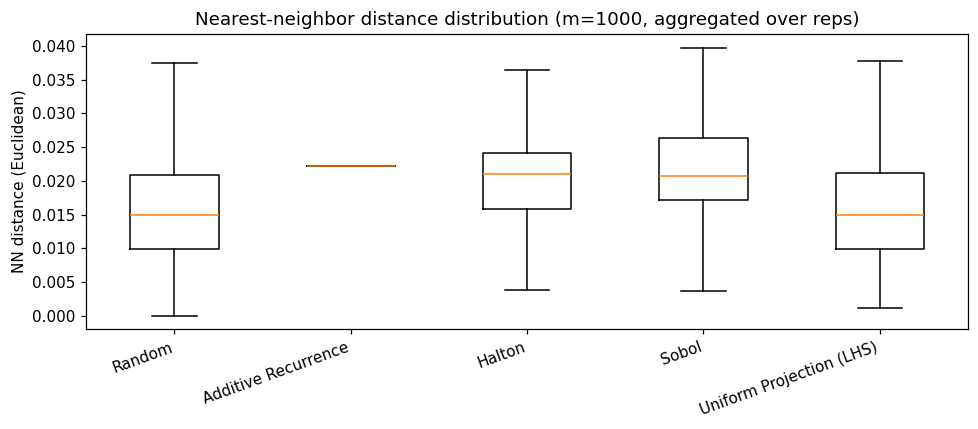

In [6]:
# =========================
# 5) Visualization: NN boxplot
# =========================

def plot_nn_boxplot(
    nn_store: Dict[Tuple[str, int], List[np.ndarray]],
    m_target: int,
    methods: List[str],
    savepath: Path | None = None,
) -> plt.Figure:
    data = []
    labels = []

    for method in methods:
        key = (method, m_target)
        if key not in nn_store:
            continue
        nn_all = np.concatenate(nn_store[key], axis=0)
        data.append(nn_all)
        labels.append(METHOD_LABEL[method])

    fig, ax = plt.subplots(figsize=(9, 4))
    ax.boxplot(data, tick_labels=labels, showfliers=False)  # tick_labels fixes the warning
    ax.set_title(f"Nearest-neighbor distance distribution (m={m_target}, aggregated over reps)")
    ax.set_ylabel("NN distance (Euclidean)")
    plt.xticks(rotation=20, ha="right")
    plt.tight_layout()

    if savepath is not None:
        fig.savefig(savepath, bbox_inches="tight")
        print("Saved:", savepath)

    return fig


nn_box_path = IMG_DIR / "fig_metric_nn_boxplot_m1000_v2.png"
_ = plot_nn_boxplot(nn_store, m_target=1000, methods=METHOD_LIST, savepath=nn_box_path)
plt.show()


Saved: img\fig_metric_discrepancy_trend_v2.png


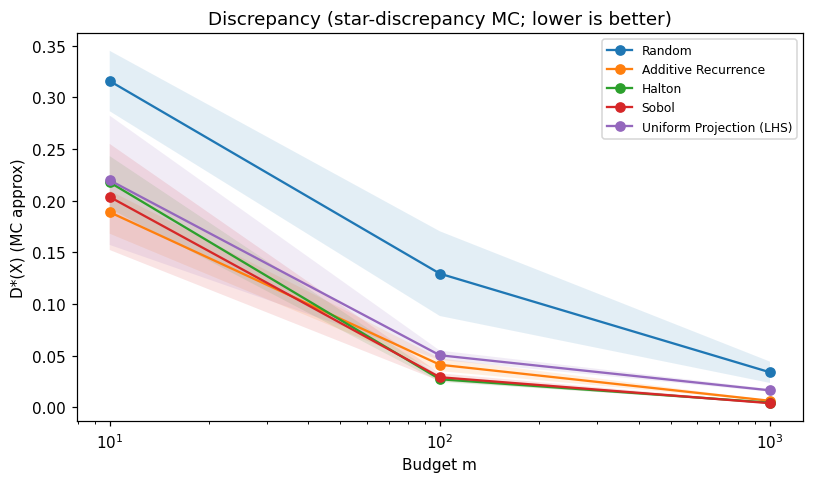

Saved: img\fig_metric_phi1_trend_v2.png


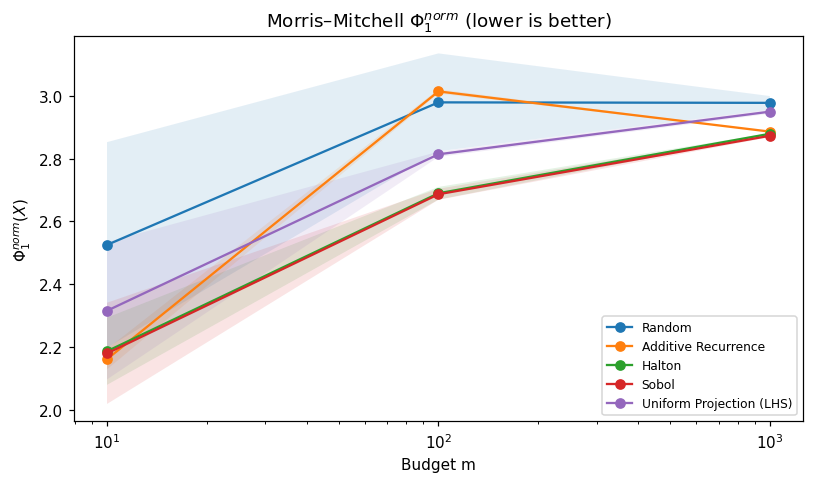

Saved: img\fig_metric_phi10_trend_v2.png


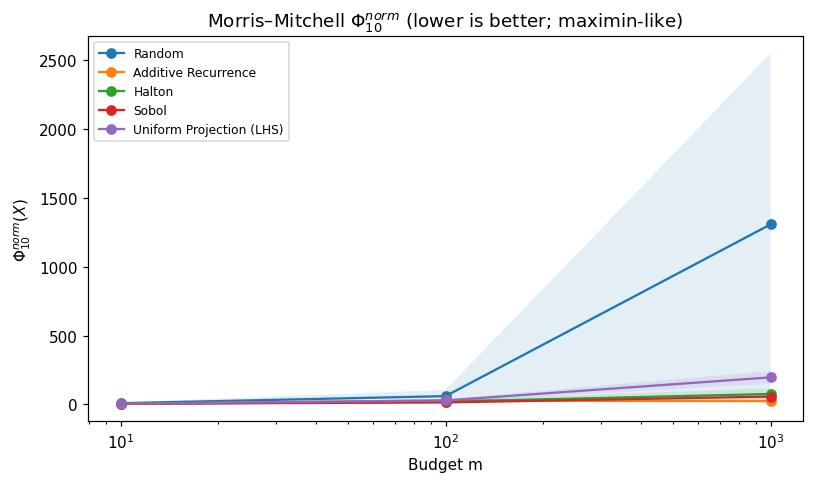

In [7]:
# =========================
# 6) Visualization: metric trends vs m
# =========================

def _summary_pick(df_summary: pd.DataFrame, metric: str) -> pd.DataFrame:
    out = df_summary[[
        "method_label",
        "m",
        f"{metric}_mean",
        f"{metric}_std",
    ]].copy()
    out = out.rename(columns={f"{metric}_mean": "mean", f"{metric}_std": "std"})
    return out


def plot_metric_trend(
    df_summary: pd.DataFrame,
    metric: str,
    title: str,
    ylabel: str,
    methods: List[str],
    savepath: Path | None = None,
    x_log: bool = True,
) -> plt.Figure:
    tidy = _summary_pick(df_summary, metric)

    fig, ax = plt.subplots(figsize=(7.5, 4.5))
    for method in methods:
        label = METHOD_LABEL[method]
        sub = tidy[tidy["method_label"] == label].sort_values("m")
        ax.plot(sub["m"], sub["mean"], marker="o", label=label)
        ax.fill_between(sub["m"], sub["mean"] - sub["std"], sub["mean"] + sub["std"], alpha=0.12)

    ax.set_title(title)
    ax.set_xlabel("Budget m")
    ax.set_ylabel(ylabel)
    if x_log:
        ax.set_xscale("log")
    ax.legend(fontsize=8, loc="best")
    plt.tight_layout()

    if savepath is not None:
        fig.savefig(savepath, bbox_inches="tight")
        print("Saved:", savepath)

    return fig


disc_trend_path = IMG_DIR / "fig_metric_discrepancy_trend_v2.png"
_ = plot_metric_trend(
    df_summary=df_summary,
    metric="disc_star_mc",
    title="Discrepancy (star-discrepancy MC; lower is better)",
    ylabel="D*(X) (MC approx)",
    methods=METHOD_LIST,
    savepath=disc_trend_path,
)
plt.show()

phi1_trend_path = IMG_DIR / "fig_metric_phi1_trend_v2.png"
_ = plot_metric_trend(
    df_summary=df_summary,
    metric="phi_q1",
    title=r"Morris–Mitchell $\Phi^{norm}_1$ (lower is better)",
    ylabel=r"$\Phi^{norm}_1(X)$",
    methods=METHOD_LIST,
    savepath=phi1_trend_path,
)
plt.show()

phi10_trend_path = IMG_DIR / "fig_metric_phi10_trend_v2.png"
_ = plot_metric_trend(
    df_summary=df_summary,
    metric="phi_q10",
    title=r"Morris–Mitchell $\Phi^{norm}_{10}$ (lower is better; maximin-like)",
    ylabel=r"$\Phi^{norm}_{10}(X)$",
    methods=METHOD_LIST,
    savepath=phi10_trend_path,
)
plt.show()


## 7) Quick ranking tables (optional, but useful for writing conclusions)

We rank methods per budget \(m\) for each metric:
- Discrepancy: **ascending** (lower better)
- NN-min: **descending** (higher better)
- \(\Phi_1\): **ascending** (lower better)

Saved to `results/rankings.csv`.


In [8]:
# =========================
# 7) Rankings (optional)
# =========================

def build_rankings(df_summary: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for m in sorted(df_summary["m"].unique()):
        sub = df_summary[df_summary["m"] == m].copy()

        def rank_metric(col_mean: str, ascending: bool) -> pd.Series:
            return sub[col_mean].rank(method="min", ascending=ascending).astype(int)

        sub["rank_discrepancy"] = rank_metric("disc_star_mc_mean", ascending=True)
        sub["rank_nn_min"] = rank_metric("nn_min_mean", ascending=False)
        sub["rank_phi1"] = rank_metric("phi_q1_mean", ascending=True)
        sub["rank_avg3"] = (sub["rank_discrepancy"] + sub["rank_nn_min"] + sub["rank_phi1"]) / 3.0

        keep = sub[[
            "m", "method_label",
            "disc_star_mc_mean", "nn_min_mean", "phi_q1_mean",
            "rank_discrepancy", "rank_nn_min", "rank_phi1", "rank_avg3"
        ]].copy()
        rows.append(keep)

    return pd.concat(rows, ignore_index=True).sort_values(["m", "rank_avg3", "method_label"])


rank_df = build_rankings(df_summary)
rank_path = RES_DIR / "rankings.csv"
rank_df.to_csv(rank_path, index=False)
print("Saved:", rank_path)

rank_df


Saved: results\rankings.csv


,m,method_label,disc_star_mc_mean,nn_min_mean,phi_q1_mean,rank_discrepancy,rank_nn_min,rank_phi1,rank_avg3
0,10,Additive Recurrence,0.188903,0.159892,2.161346,1,2,1,1.333333
1,10,Halton,0.217778,0.174116,2.186632,3,1,3,2.333333
4,10,Sobol,0.203655,0.154300,2.179905,2,3,2,2.333333
2,10,Uniform Projection (LHS),0.219784,0.152984,2.315627,4,4,4,4.000000
3,10,Random,0.315862,0.101397,2.525352,5,5,5,5.000000
9,100,Sobol,0.029134,0.034269,2.686646,2,1,1,1.333333
6,100,Halton,0.027199,0.027398,2.689817,1,2,2,1.666667
5,100,Additive Recurrence,0.041233,0.022264,3.014292,3,3,5,3.666667
7,100,Uniform Projection (LHS),0.050392,0.016857,2.813962,4,4,3,3.666667
8,100,Random,0.129405,0.011091,2.979371,5,5,4,4.666667


# 8) What you achieved & how to write it (short guidance)

### Achieved (matches teammate request)
- End-of-chapter-style comparison figure for 5 methods at 3 budgets
- 3 metrics computed + summarized over multiple repetitions
- Report-friendly visuals saved to `img/`

### Notes / caveats to mention in report
- Discrepancy is **Monte Carlo approximation** (depends on `R`). We kept `R` fixed per budget for fair comparison.
- \(\Phi_q\) uses a **normalized** formulation so trends across budgets are readable (still consistent for within-budget comparisons).
- Sobol is generated via `random_base2` and sliced → avoids warnings and preserves Sobol’s balance properties.

### Easy improvements (if you have time)
- Increase `n_reps` from 5 → 10 for tighter std bands.
- Increase discrepancy `disc_R_large` if runtime allows.
- Add one more budget (e.g., `m=300`) to show mid-scale behavior.
